In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# importing data

In [3]:
#loading data
file_1="../Dataset/B0005_dis_dataset.csv"
file_2="../Dataset/B0006_dis_dataset.csv"
dataset_1=pd.read_csv(file_1)
dataset_2=pd.read_csv(file_2)

C_max=2.05

#renaming columns for simplicity
dataset_1.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_1["current_load"]= abs(dataset_1["current_load"])

#removing ideling / starting and ending current level data  
df_1=dataset_1[(dataset_1.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_1["time"]=df_1["time"]/3600

#calculate Soc for each cycle
cycle_count=df_1["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_1[df_1['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_1["Soc"] = [(q / C_max) for q in Soc_list]
df_1["Soh"]=df_1["capacity"]/C_max

# selecting parameters 
att_=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
att=["cycle","current_load","voltage_load","Soc","time"]
X_axis="cycle"

#seperating dataset
X_train = df_1[att]
y_train = df_1[["Soh"]]



#renaming columns for simplicity
dataset_2.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_2["current_load"]= abs(dataset_2["current_load"])

#removing ideling / starting and ending current level data  
df_2=dataset_2[(dataset_2.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_2["time"]=df_2["time"]/3600

#calculate Soc for each cycle
cycle_count=df_2["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_2[df_2['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_2["Soc"] = [(q / C_max) for q in Soc_list]
df_2["Soh"]=df_2["capacity"]/C_max

X_test = df_2[att]
y_test = df_2[["Soh"]]

# Train random forest model

In [4]:
#making models
regressor1 = RandomForestRegressor(n_estimators=100,random_state=0)
regressor1.fit(X_train,y_train.values.ravel())

RandomForestRegressor(random_state=0)

# Training Lstm model

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(25, activation='tanh', recurrent_activation='sigmoid', return_sequences=True,input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

d:\Work\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train, epochs=200,batch_size=32, verbose=1,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1009 - val_loss: 1.0269e-04
Epoch 2/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0515e-04 - val_loss: 4.1750e-04
Epoch 3/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.3477e-05 - val_loss: 4.3843e-04
Epoch 4/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.5334e-05 - val_loss: 4.1785e-04
Epoch 5/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.6164e-05 - val_loss: 1.3147e-04
Epoch 6/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2.4696e-05 - val_loss: 8.3434e-05
Epoch 7/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.4776e-05 - val_loss: 1.6689e-05
Epoch 8/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 8.3117e-06 - val_loss: 4.2135e-05
Epoch 9/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.1895e-06 - val_loss: 1.1695e-05
Epoch 10/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3.9326e-06 - val_loss: 1.0976e-05
Epoch 11/200
1129/1129 ━━━━━━━━━

# making prediction

In [7]:
#poly Prediction
rfr_predictions = regressor1.predict(X_test)

# LSTM Predictions
X_test_scaled = scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
lstm_predictions = lstm_model.predict(X_test_lstm)

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


# stacking prediction

In [8]:
# Calculate performance weighted average

rmse_rfr = np.sqrt(metrics.mean_squared_error(y_test, rfr_predictions))
rmse_lstm = np.sqrt(metrics.mean_squared_error(y_test, lstm_predictions))

# Assign weights inversely proportional to MSE

weight_rfr = 1 / rmse_rfr
weight_lstm = 1 / rmse_lstm
total_weight = weight_rfr + weight_lstm
weight_rfr /= total_weight
weight_lstm /= total_weight

In [9]:
rmse_rfr

0.03645418921488549

In [10]:
rfr_predictions = rfr_predictions.reshape(len(rfr_predictions),1)

In [11]:
# Combine predictions
combined_predictions = (weight_rfr * rfr_predictions + weight_lstm * lstm_predictions)

# graph

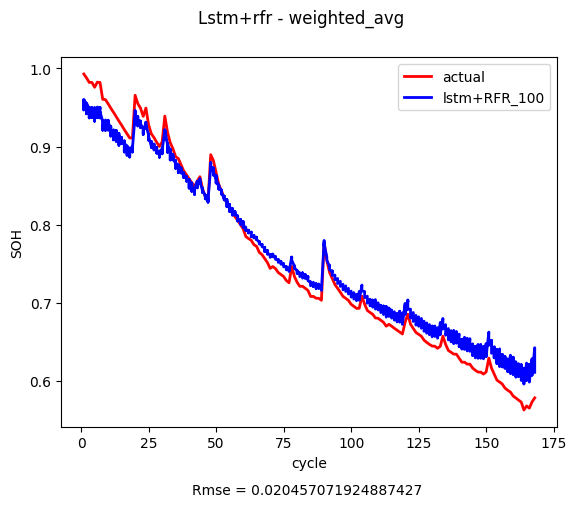

0.020457071924887427


In [13]:
plt.plot(X_test["cycle"],y_test,color='red',label='actual',linewidth=2)
plt.plot(X_test["cycle"],combined_predictions,color='blue',label="lstm+RFR_100",linewidth=2)
plt.xlabel("cycle")
plt.ylabel("SOH")
rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test,combined_predictions)))
plt.figtext(0.33, -0.03, rmse, fontsize=10)
plt.legend(loc="upper right")
plt.suptitle("Lstm+rfr - weighted_avg")
plt.show()
print(np.sqrt(metrics.mean_squared_error(y_test,combined_predictions)))